# FAKES NEW DETECTION
## Classification avec un réseaux de neurones convolutionnels - CNN

<img src="images/news_pred_example.jpg" width="800" height="800" align="center"/>

Dans ce notebook, nous allons créer un classificateur CNN (Convolutional Neural Network) pour prédire la catégorie des actualités (vrais, faux).

Nous allons utilisé une dataset crée avec la technique de scraping pour récupérer les articles depuis des sites qui publient des fausses articles ou des contenus ironiques. 
Pour plus de détails sur le dataset voir le notebook  `data_analytics.ipynb`

We will:
- Prétraitement des données de texte pour la NLP
- Construisez et formez un modele CNN 1-D en utilisant Keras et Tensorflow
- Évaluez notre modèle sur l'ensemble de test
- Exécutez le modèle sur nos propres dataset


## Configuration initiale

Commençon par l'imporatation des packages nécessaires

In [14]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Flatten, Conv1D, Dropout, Activation
from tensorflow.keras.preprocessing.text import Tokenizer

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import re
import string

## Parameteres de training

Nous allons définir les hyperparamètres pour le training de notre modèle. N'hésitez pas à jouer - sinon, nous vous recommandons de conserver les valeurs par défaut pour votre première exécution.

In [15]:
# Hyperparams if GPU is available
if len(tf.config.list_physical_devices('GPU')) > 0:
    # GPU
    BATCH_SIZE = 128 # Number of examples used in each iteration
    EPOCHS = 4 # Number of passes through entire dataset
    VOCAB_SIZE = 90000 # Size of vocabulary dictionary
    MAX_LEN = 1000 # Max length of news (in words)
    EMBEDDING_DIM = 40 # Dimension of word embedding vector

# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 120
    EPOCHS = 4
    VOCAB_SIZE = 30000
    MAX_LEN = 500
    EMBEDDING_DIM = 40

In [16]:
from sklearn.utils import resample

fakenews = pd.read_csv("output/fake_news_cleaned.csv", usecols=['title','text'])
realnews = pd.read_csv("output/real_news_cleaned.csv", usecols=['title','text'])
#resample dataset
realnews = resample(realnews, replace=False, n_samples=len(fakenews), random_state=0)

LABELS = ['fake', 'true']
fakenews['label'] = 0
realnews['label'] = 1

In [17]:
# fusionnée les 2 dataset
df_news = pd.concat([fakenews, realnews])
# permutation des données 
df_news = df_news.sample(len(df_news), random_state=4)

#### Voir l'echantillons du dataset

In [18]:
df_news.sample(10)

,title,text,label
10079,volvo s90 la suédoise élégante sud ouest,la s90 reçoit une calandre similaire à celle d...,1
2783,volkswagen peut on refuser la mise à jour du l...,02 estimant que le constructeur allemand est ...,1
478,5 preuves que vous devez démissionner pour dev...,plus un français sur quatre ressent aujourd hu...,0
5536,primaire de gauche primaire de droite le jeu d...,pour la première fois à la fois droite et gauc...,1
4222,alerte le signal de botrange entre en éruption,le signal de botrange vient tout juste entrer ...,0
2061,la valla sur rochefort un enfant de 5 ans et u...,loire la valla sur rochefort un enfant de 5 an...,1
7333,laurent surpris à mal porter son masque pendan...,ouh il porte pas bien son masque est pas bien ...,0
929,amiens amazon va ouvrir un 5e centre de distri...,société amiens amazon va ouvrir un 5e centre d...,1
3531,simplification administrative aéroport de pari...,roissy orly régulièrement critiqué par les com...,0
7120,victoire de algérie à la can abdelaziz boutefl...,les fennecs ont battu la côte ivoire aux tirs...,0


In [19]:
# préparation de donnée de training(80%), validation(20%)
L = len(df_news)
train, val = df_news[:int(L * 0.8)].reset_index(), df_news[int(L * 0.8):].reset_index()

voir la distribution de données de training et validation

Training count : fake = 5990, real 5997
Validation count : fake = 1502, real 1495


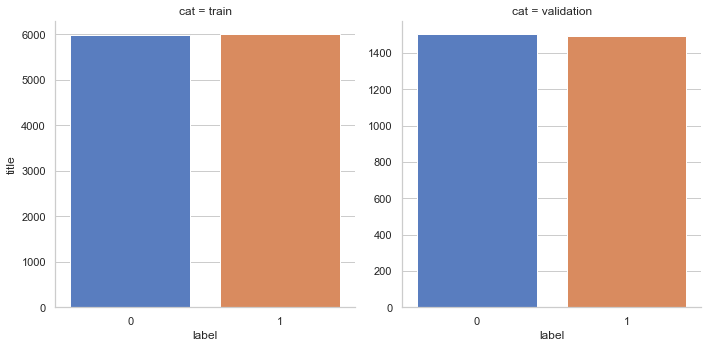

In [20]:
import seaborn as sns

sns.set(style="whitegrid")

train['cat'] = 'train'
val['cat'] = 'validation'

df_concat = pd.concat([train, val]).groupby(["label", "cat"]).count().reset_index()
g = sns.catplot(x="label", y="title", col="cat", data=df_concat, sharey=False, kind="bar", palette="muted")

print("Training count : fake = {0}, real {1}".format(df_concat.iloc[0]['title'], df_concat.iloc[2]['title']))
print("Validation count : fake = {0}, real {1}".format(df_concat.iloc[1]['title'], df_concat.iloc[3]['title']))

In [21]:
print('texte : \n', train['text'][0], "\n")
print('label : ', train['label'][0])

texte : 
 le chanteur pitbull qui devait faire la première partie de kevin bazinet aux grandes fêtes cet été est maintenant interdit à rimouski en prenant connaissance du règlement municipal tout ce qui porte de nom de pitt ou de bull ne peut franchir les limites de la ville la semaine dernière pitbull laissé aller son instinct hétérophile et aurait violemment mordu arrière train de la chanteuse jennifer lope après cet incident son gérant été formellement accusé agression aucune accusation été porté envers le chanteur car comme tout le monde le sait peu importe ce qui arrive avec un animal surtout un pitbull est toujours la faute du maître pitbull déclare avoir eu un dressage misogyne durant son enfance et qu il toujous aucune idée de ce que ça veut dire une pétition circule au bar chez pull afin de changer le règlement pour que les douches de rimouski puissent enfin rencontrer leur idole  

label :  0


In [22]:
from nltk.corpus import stopwords

stoplist = stopwords.words('french')

#delete stopwords
def remove_stop_words(tokens):
    return [word for word in tokens if word not in stoplist]

# Custom Tokenizer
def text_normalization(text):
    text = re.sub(u"[^A-Za-z0-9(),!?\'\`:/\-\.]", u" ", text)
    text = re.sub(u'&#8217;',u"'",text)
    text = re.sub(u'\u2019',u"'",text)
    text = re.sub(u'&#160;',u" ",text)
    text = re.sub(u'&#8211;',u"-",text)
    text = re.sub(u'\u000a',u"",text)
    text = re.sub(u'\u2014',u"-",text)
    text = re.sub(u'\n+$',u" ",text)
    text = re.sub(u'\s+',u" ",text)
    text = re.sub(u'^\s+',u"",text)
    text = re.sub(u'\s+$',u"",text)
    text = re.sub(u"\'s", u" \'s", text)
    text = re.sub(u"\'ve", u" \'ve", text)
    text = re.sub(u"n\'t", u" n\'t", text)
    text = re.sub(u"\'re", u" \'re", text)
    text = re.sub(u"\'d", u" \'d", text)
    text = re.sub(u"\'ll", u" \'ll", text)
    text = re.sub(u",", u" , ", text)
    text = re.sub(u"!", u" ! ", text)
    text = re.sub(u"\(", u" ( ", text)
    text = re.sub(u"\)", u" ) ", text)
    text = re.sub(u"\?", u" ? ", text)
    text = re.sub(u"\.{2,}",u" . ", text)
    text = re.sub(u":[^/]",u" : ", text)
    text = re.sub(u"\s{2,}",u" ", text)
    return text

def lower_token(tokens):
    return [w.lower() for w in tokens]

def tokenize(s):    
    return lower_token(text_normalization(s).split())

In [23]:
#clean text
train['text_clean'] = train['text'].apply(lambda x: text_normalization(x))
val['text_clean'] = val['text'].apply(lambda x: text_normalization(x))
#remove stop words
train['text_clean'] = [ ' '.join(remove_stop_words(text.split())) for text in train['text_clean'] ]
val['text_clean'] = [ ' '.join(remove_stop_words(text.split())) for text in val['text_clean'] ]

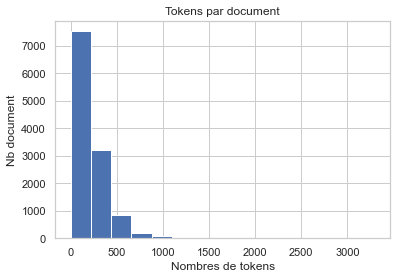

In [24]:
# Plot sentence by length
train['tokens'] = train['text_clean'].apply(lambda x: tokenize(x))
tokens_len = [len(s) for s in train['tokens'].values]
plt.hist(tokens_len, bins=15)
plt.title('Tokens par document')
plt.xlabel('Nombres de tokens')
plt.ylabel('Nb document')
plt.show()

Avoir des informations sur la taille des vocabulaires et sur le text

In [25]:
all_training_words = [word for tokens in train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in train["tokens"]]
train_vocab = sorted(list(set(all_training_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(train_vocab)))
print("Max sentence length is %s" % max(training_sentence_lengths))

2739223 words total, with a vocabulary size of 92179
Max sentence length is 3299


## Data Preprocessing

Avant de mettre les données dans le modèle, nous devons prétraiter le texte.

- Nous utiliserons le `Tokenizer` de Keras pour convertir chaque mot en un ID entier correspondant. Représenter les mots sous forme d'entiers économise beaucoup de mémoire!
- Afin d'introduire le texte dans notre CNN, tous les textes doivent être de la même longueur. Nous assurons cela en utilisant la méthode `sequence.pad_sequences ()` et la variable `MAX_LEN`. Tous les textes plus longs que `MAX_LEN` sont tronqués et les textes plus courts sont remplis par des zéros pour les obtenir à la même longueur.

Le graph **Tokens par document** (voir ci-dessus) est utile pour définir l'hyperparamètre d'entraînement `MAX_LEN`.

In [26]:
text_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
text_tokenizer.fit_on_texts(train['text_clean'].values)

x_train_seq = text_tokenizer.texts_to_sequences(train['text_clean'].values)
x_val_seq = text_tokenizer.texts_to_sequences(val['text_clean'].values)

x_train = sequence.pad_sequences(x_train_seq, maxlen=MAX_LEN, padding="post", value=0)
x_val = sequence.pad_sequences(x_val_seq, maxlen=MAX_LEN, padding="post", value=0)

y_train, y_val = train['label'].values, val['label'].values

print('First sample before preprocessing: \n', train['text_clean'].values[0], '\n')
print('First sample after preprocessing: \n', x_train[0])

First sample before preprocessing: 
 chanteur pitbull devait faire premi re partie kevin bazinet grandes f cet maintenant interdit rimouski prenant connaissance r glement municipal tout porte nom pitt bull peut franchir limites ville semaine derni re pitbull laiss aller instinct h rophile violemment mordu arri re train chanteuse jennifer lope apr cet incident g rant formellement accus agression aucune accusation port envers chanteur car comme tout monde sait peu importe arrive animal surtout pitbull toujours faute tre pitbull clare avoir dressage misogyne durant enfance toujous aucune id e a veut dire p tition circule bar chez pull afin changer r glement douches rimouski puissent enfin rencontrer idole 

First sample after preprocessing: 
 [ 1458 22084   816    14    77     5   183  2508   738    32   113   392
  1672  6795  3153  2301     1  2247  2583    10   234   146  5497  5767
    49  5768  2983   115   212   121     5 22084  1079   345 11488    54
  4465 14295  1360     5   500 

## Model

Nous mettrons en œuvre un modèle similaire à celui de Kim Yoon’s [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882).

![cnn for text](images/cnn.png)


*Image à partir la [source](https://arxiv.org/abs/1408.5882)*

In [27]:
# Model Parameters
NUM_FILTERS = 120
KERNEL_SIZE = 2
HIDDEN_DIMS = 200

In [28]:
# CNN Model
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into EMBEDDING_DIM dimensions
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn NUM_FILTERS filters
model.add(Conv1D(NUM_FILTERS,
                 KERNEL_SIZE,
                 padding='valid',
                 activation='relu',
                 strides=1))

# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(HIDDEN_DIMS))
model.add(Dropout(0.1))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 40)           1200000   
_________________________________________________________________
dropout (Dropout)            (None, 500, 40)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 499, 120)          9720      
_________________________________________________________________
global_max_pooling1d (Global (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               24200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
activation (Activation)      (None, 200) 

## Train & Evaluate

Avec les paramètres et hyperparamètres ci-dessous, le training devrait durer envrion: 

- sur une machine CPU: 1 minutes pour 3 epochs.
- sur une machine GPU: 1 minute pour 2 epochs.

Vous devriez obtenir une accuracy de > 97%. 

*Note*: Le modèle commencera à sur-ajuster(overfitting) après 4 epochs.

In [29]:
# fit a model
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.1,
          verbose=2)

# Evaluate the model
score, acc = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE)

print('\nAccuracy: ', acc * 100)

Train on 10788 samples, validate on 1199 samples
Epoch 1/4
10788/10788 - 20s - loss: 0.4843 - accuracy: 0.7763 - val_loss: 0.2184 - val_accuracy: 0.9141
Epoch 2/4
10788/10788 - 20s - loss: 0.1161 - accuracy: 0.9584 - val_loss: 0.1379 - val_accuracy: 0.9525
Epoch 3/4
10788/10788 - 19s - loss: 0.0429 - accuracy: 0.9877 - val_loss: 0.1296 - val_accuracy: 0.9508
Epoch 4/4
10788/10788 - 19s - loss: 0.0113 - accuracy: 0.9982 - val_loss: 0.1322 - val_accuracy: 0.9550
2997/2997 [==============================] - ETA: 0s - loss: 0.0825 - accuracy: 0.96 - 1s 491us/sample - loss: 0.0812 - accuracy: 0.9690

Accuracy:  96.89689874649048


              precision    recall  f1-score   support

        fake       0.98      0.96      0.97      1523
        true       0.96      0.98      0.97      1474

    accuracy                           0.97      2997
   macro avg       0.97      0.97      0.97      2997
weighted avg       0.97      0.97      0.97      2997



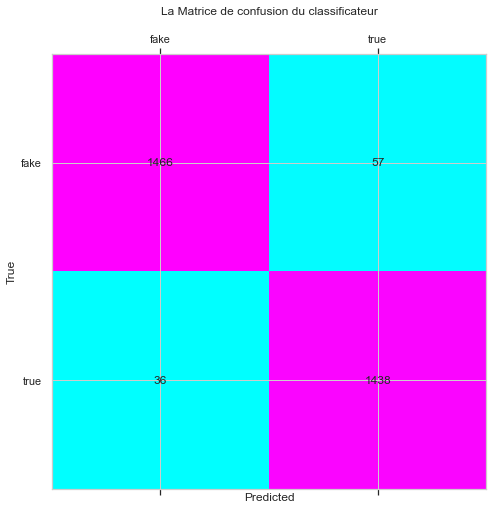

In [30]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

pred = model.predict_classes(x_val)

cnf_matrix = confusion_matrix(pred, y_val)

# Print Precision Recall F1-Score Report
from sklearn.metrics import classification_report

report = classification_report(pred, y_val, target_names=LABELS)
print(report)

fig, ax = plt.subplots(1,1, figsize=(8,8))

cax = ax.matshow(cnf_matrix, cmap='cool')

plt.title('La Matrice de confusion du classificateur\n')
ax.set_xticklabels([''] + LABELS)
ax.set_yticklabels([''] + LABELS)

for (i, j), z in np.ndenumerate(cnf_matrix):
    ax.text(j, i, z, ha='center', va='center')
    
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Resultat

Avec une architecture simple de réseaux de neurones et avec une dataset petite on a eu une précision de 97% ce qui explique l'utilisation de l'architecture CNN dans le domaine des NLP

#### Hyperparamètres utilisés


|Paramètre| Description| Valeur |
|-------------- |----------- |----------- |
|BATCH_SIZE|Nombre d'exemples utilisés dans chaque itération|120|
|EPOCHS|Nombre de passages dans l'ensemble de données|4|
|VOCAB_SIZE|Taille du dictionnaire de vocabulaire|30000|
|MAX_LEN|Max length of des mots d'article|500|
|EMBEDDING_DIM|Dimension du vecteur de mots|40|
|HIDDEN_DIMS|dimension de couche cachée|200|
|NUM_FILTERS|Nombre de filtres|120|
|KERNEL_SIZE|Taille de filtres|2|
|Padding|Rembourage|0|
|Stride|Taille de pas|1|
|Fonction d'activation||Sigmoid|


## Quelques exemples

On va utiliser la librarie `newspaper` pour récuéprer des articles

In [184]:
from newspaper import Article

In [218]:
def get_prediction(text):
    # Preprocessing
    text_np_array = text_tokenizer.texts_to_sequences([text])
    text_np_array = sequence.pad_sequences(text_np_array, maxlen=MAX_LEN, padding="post", value=0)
    # Prediction
    score = model.predict(text_np_array)[0][0]
    #print('test ', model.predict(text_np_array))
    prediction = LABELS[model.predict_classes(text_np_array)[0][0]]
    print('\nPREDICTION:', prediction, '\nSCORE: ', score)

In [250]:
links = [
   'https://nordpresse.be/alerte-tsunami-7-metres-neige-demain-belgique-france/',
   'https://sud-ou-est.fr/la-dune-du-pilat-33-au-programme-du-tour-de-france-2015/',
    'http://www.legorafi.fr/2020/03/31/bruno-le-maire-appelle-a-la-fondation-dune-nouvelle-internationale-ouvriere-et-a-mettre-a-bas-le-capitalisme-qui-exploite-les-camarades'
]

fake_articles = []

#data collect
for link in links:
    article = Article(link, language='fr')
    article.download()
    article.parse()    
    fake_articles.append(article)
    

In [252]:
from IPython.display import Image, display

#prediction
for article in fake_articles:
    display(Image(url=article.top_image,width=300))
    print("TITRE : %s" %article.title)
    print('\nDESCRIPTION : %s...' %article.text[:500])
    get_prediction(article.text)
    print('-' * 150)

TITRE : Alerte Tsunami ! 7 mètres de neige demain sur toute la Belgique et la France

DESCRIPTION : Tous les ménages doivent se prémunir contre le grand froid qui s’annonce cette nuit et la quantité de neige astronomique prévue sur l’ouest de l’Europe. Il se pourrait que 7 mètres de neige tombent pendant la nuit et provoque un véritable chaos en Belgique et en France. Ceci à cause d’un tsunami neigeux unique provoqué par l’inversion de température due à la micro-éruption du volcan Brennisteinsfjöll.

Depuis l’inversion de température de ces derniers jours, la prévision d’une chute de neige col...
test  [[0.00050456]]

PREDICTION: fake 
SCORE:  0.00050455617
------------------------------------------------------------------------------------------------------------------------------------------------------


TITRE : La dune du Pilat (33) au programme du Tour de France 2015 ?

DESCRIPTION : Chagrinés de voir la plus belle épreuve cycliste du monde s’écarter des routes de Gironde, les membres du conseil municipal de la Teste-de-Buch ont contacté la direction du Tour du France, en vue de la Grande Boucle 2015, pour proposer une étape inédite : un contre-la-montre sur le bassin d’Arcachon ponctué d’une arrivée en moyenne montagne, au sommet de la Dune du Pilat.

Jean-Didier CAZENAVE, président du club local “La Pédale Testerine”, à l’origine du projet, se montre volontiers bavard : « ...
test  [[0.00047716]]

PREDICTION: fake 
SCORE:  0.0004771645
------------------------------------------------------------------------------------------------------------------------------------------------------


TITRE : Bruno Le Maire appelle à la fondation d’une nouvelle Internationale Ouvrière et à mettre à bas le capitalisme qui exploite les camarades

DESCRIPTION : Après son appel pour demander un nouveau capitalisme, Bruno Le Maire n’est pas resté sans rien faire. Ce matin, il appelait ainsi à la création d’une nouvelle internationale des Ouvriers et des Travailleurs et à mettre à bas le système capitalistique qui exploite depuis trop longtemps les camarades du monde entier. Reportage.

C’est le point levé du balcon d’un de ses bureaux de Bercy que Bruno Le Maire a tenté de haranguer les rares personnes dans la rue qui bravaient le confinement. « Ensemble...
test  [[6.463103e-08]]

PREDICTION: fake 
SCORE:  6.463103e-08
------------------------------------------------------------------------------------------------------------------------------------------------------


In [253]:
links = [
    'http://www.europe1.fr/societe/625-kg-de-resine-de-cannabis-saisis-pres-de-la-frontiere-franco-espagnole-2861041',
    'http://www.lepoint.fr/monde/syrie-msf-reclame-la-fin-du-bain-de-sang-a-alep-assiegee-01-10-2016-2072741_24.php',
    'http://www.lemonde.fr/europe/article/2016/10/04/en-turquie-plus-de-12-000-policiers-mis-a-pied-dans-l-enquete-sur-le-putsch-rate_5007797_3214.html'  
]

true_articles = []

#data collect
for link in links:
    article = Article(link, language='fr')
    article.download()
    article.parse()    
    true_articles.append(article)
    

In [254]:
from IPython.display import Image, display

#prediction
for article in true_articles:
    display(Image(url=article.top_image,width=300))
    print("TITRE : %s" %article.title)
    print('\nDESCRIPTION : %s...' %article.text[:500])
    get_prediction(article.text)
    print('-' * 150)

TITRE : 625 kg de résine de cannabis saisis près de la frontière franco-espagnole

DESCRIPTION : Les douaniers du Perthus, dans les Pyrénées-Orientales, ont saisi en début de semaine 625 kg de résine de cannabis, d'une valeur estimée à 3,8 millions d'euros, dans un camion frigorifique dont le chauffeur a été interpellé, ont indiqué les douanes vendredi.

Transport de "boîtes en plastique". La découverte a eu lieu lundi, lors d'un contrôle sur l'autoroute A9 au niveau du péage du Boulou, situé à une dizaine de kilomètres de la frontière espagnole, ont précisé les douanes dans un communiqué. ...
test  [[0.3783687]]

PREDICTION: fake 
SCORE:  0.3783687
------------------------------------------------------------------------------------------------------------------------------------------------------


TITRE : Syrie : MSF réclame la fin du "bain de sang" à Alep assiégée

DESCRIPTION : Le régime de Damas a progressé face aux rebelles dans Alep, bénéficiant notamment des frappes de son allié russe qui ont tué plus de 3 800 civils en un an de campagne militaire en Syrie. Médecins sans frontières (MSF) a appelé vendredi Damas et Moscou à mettre un terme « au bain de sang » à Alep, principal front du conflit qui ravage le pays depuis cinq ans. L'avancée de l'armée syrienne survient au moment où les États-Unis et la Russie, parrains respectifs de l'opposition et du régime, semblent...
test  [[0.9909746]]

PREDICTION: true 
SCORE:  0.9909746
------------------------------------------------------------------------------------------------------------------------------------------------------


TITRE : En Turquie, plus de 12 000 policiers mis à pied dans l’enquête sur le putsch raté

DESCRIPTION : Policiers turcs à Istanbul, en janvier. BULENT KILIC / AFP

Plus de 12 000 policiers ont été mis à pied en Turquie pour des liens présumés avec l’ex-prédicateur Fethullah Gülen, accusé d’avoir ourdi le putsch avorté de la mi-juillet. Sur 12 801 policiers mis à pied, 2 523 sont des gradés, selon la police. La force de police en Turquie compte 270 000 hommes et femmes.

Depuis la tentative de coup d’Etat, imputée à M. Gülen, en exil volontaire aux Etats-Unis depuis 1999, les autorités turques ont ...
test  [[0.99950814]]

PREDICTION: true 
SCORE:  0.99950814
------------------------------------------------------------------------------------------------------------------------------------------------------


## Sauvegarder le modèle

In [32]:
import pickle

# Saving Tokenizer
with open('models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(text_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
# Saving Model
model.save('models')

INFO:tensorflow:Assets written to: models\assets


### Charger le modèle

In [35]:
from tensorflow import keras

#Load the tokenizer
with open('models/tokenizer.pickle', 'rb') as text_tokenizer:  
    text_tokenizer = pickle.load(text_tokenizer)
    
model = keras.models.load_model('models')    